In [1]:
import tensorflow as tf
from tensorflow import keras
import scipy.io

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip '/content/drive/MyDrive/cond+data.zip'

Streaming output truncated to the last 5000 lines.
  inflating: cond+data/ideal_op/iop_668.mat  
  inflating: cond+data/ideal_op/iop_669.mat  
  inflating: cond+data/ideal_op/iop_67.mat  
  inflating: cond+data/ideal_op/iop_670.mat  
  inflating: cond+data/ideal_op/iop_671.mat  
  inflating: cond+data/ideal_op/iop_672.mat  
  inflating: cond+data/ideal_op/iop_673.mat  
  inflating: cond+data/ideal_op/iop_674.mat  
  inflating: cond+data/ideal_op/iop_675.mat  
  inflating: cond+data/ideal_op/iop_676.mat  
  inflating: cond+data/ideal_op/iop_677.mat  
  inflating: cond+data/ideal_op/iop_678.mat  
  inflating: cond+data/ideal_op/iop_679.mat  
  inflating: cond+data/ideal_op/iop_68.mat  
  inflating: cond+data/ideal_op/iop_680.mat  
  inflating: cond+data/ideal_op/iop_681.mat  
  inflating: cond+data/ideal_op/iop_682.mat  
  inflating: cond+data/ideal_op/iop_683.mat  
  inflating: cond+data/ideal_op/iop_684.mat  
  inflating: cond+data/ideal_op/iop_685.mat  
  inflating: cond+data/ideal_op

In [4]:
import numpy as np
import matplotlib.pyplot as plt
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()

In [5]:
total_act_ip=[]
total_ip=[]
min_ip=[]
max_ip=[]
for ind in range(1,2316):
  name='/content/cond+data/ip/'+'ip_'+str(ind)+'.mat'
  ip_mat = scipy.io.loadmat(name)
  min=np.min(ip_mat["S"])
  max=np.max(ip_mat["S"])
  total_act_ip.append(np.array(ip_mat["S"],dtype='float32'))
  min_ip.append(min),max_ip.append(max)

ipmin,ipmax=[],[]
for ip in total_act_ip:
  a=(ip-np.min(min_ip))/(np.max(max_ip)-np.min(min_ip))
  ipmin.append(np.min(a))
  ipmax.append(np.max(a))
  total_ip.append(a)
print(np.min(min_ip),np.max(max_ip))
print(np.min(ipmin),np.max(ipmax))

-0.006370057039312524 0.006137293239333164
0.0 1.0


In [6]:
np.shape(total_ip)

(2315, 32, 32, 4)

In [7]:
total_act_op=[]
total_op=[]
max_all=[]
m_c=[]
for ind in range(1,2316):
  name='/content/cond+data/ideal_op/'+'iop_'+str(ind)+'.mat'
  op_mat = scipy.io.loadmat(name)
  max_arr=np.max(op_mat["Ci"])
  total_act_op.append(np.array(op_mat['Ci'],dtype='float32'))
  max_all.append(max_arr)

max_overall=np.max(max_all)
for i in total_act_op:
  a=i/max_overall
  total_op.append(a)
print(max_overall)

0.24276130100000004


In [8]:
print(np.shape(total_op))

(2315, 64, 64, 2)


In [9]:
index=[x for x in range(len(total_ip))]
np.shape(index)

(2315,)

In [10]:
from sklearn.model_selection import train_test_split
train_ind,test_ind=train_test_split(index, test_size=0.05,random_state=42,shuffle=True)

In [11]:
train_ip=[total_ip[x] for x in train_ind]
train_op=[total_op[x] for x in train_ind]
test_ip=[total_ip[x] for x in test_ind]
test_op=[total_op[x] for x in test_ind]

In [12]:
print(np.shape(total_ip),np.shape(total_op))
print(np.shape(train_ip),np.shape(train_op))
print(np.shape(test_ip),np.shape(test_op))

(2315, 32, 32, 4) (2315, 64, 64, 2)
(2199, 32, 32, 4) (2199, 64, 64, 2)
(116, 32, 32, 4) (116, 64, 64, 2)


In [13]:
def psnr(y_true, y_pred):
  return tf.reduce_mean(tf.image.psnr(y_true, y_pred, max_val=1.0))

In [82]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout

inputs = Input((32,32,4))

c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs) 
c1 = BatchNormalization(axis=-1)(c1)
c1= Dropout(0.1)(c1) 
c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
p1 = MaxPooling2D((2, 2))(c1)

c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1) 
c2 = BatchNormalization(axis=-1)(c2)
c2= Dropout(0.1)(c2) 
c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
p2 = MaxPooling2D((2, 2))(c2)
  
c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
c3 = BatchNormalization(axis=-1)(c3)
c3= Dropout(0.2)(c3)
c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
p3 = MaxPooling2D((2, 2))(c3)
  
c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
c4 = BatchNormalization(axis=-1)(c4)
c4= Dropout(0.3)(c4)
c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
p4 = MaxPooling2D(pool_size=(2, 2))(c4)
  
c5 = Conv2D(512, (3, 3), activation='relu', padding='same')(p4)
c5 = BatchNormalization(axis=-1)(c5)
c5= Dropout(0.3)(c5)
c5 = Conv2D(512, (3, 3), activation='relu', padding='same')(c5)

u6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(256, (3, 3), activation='relu', padding='same')(u6)
c6 = BatchNormalization(axis=-1)(c6)
c6= Dropout(0.3)(c6)
c6 = Conv2D(256, (3, 3), activation='relu', padding='same')(c6)


u7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
c7 = BatchNormalization(axis=-1)(c7)
c7= Dropout(0.2)(c7)
c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)


u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(64, (3, 3), activation='relu', padding='same')(u8)
c8 = BatchNormalization(axis=-1)(c8)   
c8= Dropout(0.1)(c8)
c8 = Conv2D(64, (3, 3), activation='relu', padding='same')(c8)


u9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(32, (3, 3), activation='relu', padding='same')(u9)
c9 = BatchNormalization(axis=-1)(c9)
c9= Dropout(0.1)(c9)
c9 = Conv2D(32, (3, 3), activation='relu', padding='same')(c9)


c10= Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c9)
c11 = Conv2D(8, (3, 3),activation='relu', padding='same')(c10)
c12 = Conv2D(2, (3, 3),activation='relu', padding='same')(c11)

model = Model(inputs=[inputs], outputs=[c12])
model.compile(optimizer ="Adam", loss = 'msle',metrics=[psnr])
print(model.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 4)]  0           []                               
                                                                                                  
 conv2d_60 (Conv2D)             (None, 32, 32, 32)   1184        ['input_4[0][0]']                
                                                                                                  
 batch_normalization_27 (BatchN  (None, 32, 32, 32)  128         ['conv2d_60[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 dropout_27 (Dropout)           (None, 32, 32, 32)   0           ['batch_normalization_27[0]

In [83]:
from sklearn.model_selection import KFold
i=1
n_split=10

for train_index,test_index in KFold(n_split).split(train_ind):
  xtr=[train_ip[x] for x in train_index]
  ytr=[train_op[x] for x in train_index]
  xte=[train_ip[x] for x in test_index]
  yte=[train_op[x] for x in test_index]
  print("\nfold {0}".format(i))
  i=i+1
  model_1=model
  history=model_1.fit(np.array(xtr),np.array(ytr),epochs=75,validation_data=(np.array(xte),np.array(yte)))

  print('Model evaluation ',model.evaluate(np.array(xte),np.array(yte)))


fold 1
Epoch 1/75
62/62 [==============================] - 14s 42ms/step - loss: 0.0106 - psnr: 19.7854 - val_loss: 0.0144 - val_psnr: 17.0738
Epoch 2/75
62/62 [==============================] - 2s 30ms/step - loss: 0.0030 - psnr: 23.9753 - val_loss: 0.0067 - val_psnr: 20.8097
Epoch 3/75
62/62 [==============================] - 2s 29ms/step - loss: 0.0023 - psnr: 25.3440 - val_loss: 0.0059 - val_psnr: 21.5023
Epoch 4/75
62/62 [==============================] - 2s 28ms/step - loss: 0.0018 - psnr: 26.5572 - val_loss: 0.0054 - val_psnr: 22.0526
Epoch 5/75
62/62 [==============================] - 2s 28ms/step - loss: 0.0016 - psnr: 26.9742 - val_loss: 0.0045 - val_psnr: 23.2021
Epoch 6/75
62/62 [==============================] - 2s 28ms/step - loss: 0.0014 - psnr: 27.6378 - val_loss: 0.0036 - val_psnr: 24.5081
Epoch 7/75
62/62 [==============================] - 2s 29ms/step - loss: 0.0014 - psnr: 27.7524 - val_loss: 0.0031 - val_psnr: 25.0745
Epoch 8/75
62/62 [============================

In [90]:
model_1.save("EIT_model_cross_val_ipopnormalised_cond+data750.h5")

In [ ]:
model_1=tf.keras.models.load_model("/content/drive/MyDrive/EIT_model_cross_val_ipopnormalised_cond+data.h5",custom_objects={"psnr":psnr})

In [84]:
pred_op=[]
val_index=np.random.randint(len(train_ip),size=4)
for i in val_index:
  ip=train_ip[i].reshape(1,32,32,4)
  op=model_1.predict(ip,verbose=0)
  op=np.squeeze(op,axis=0)
  pred_op.append(op)

In [85]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

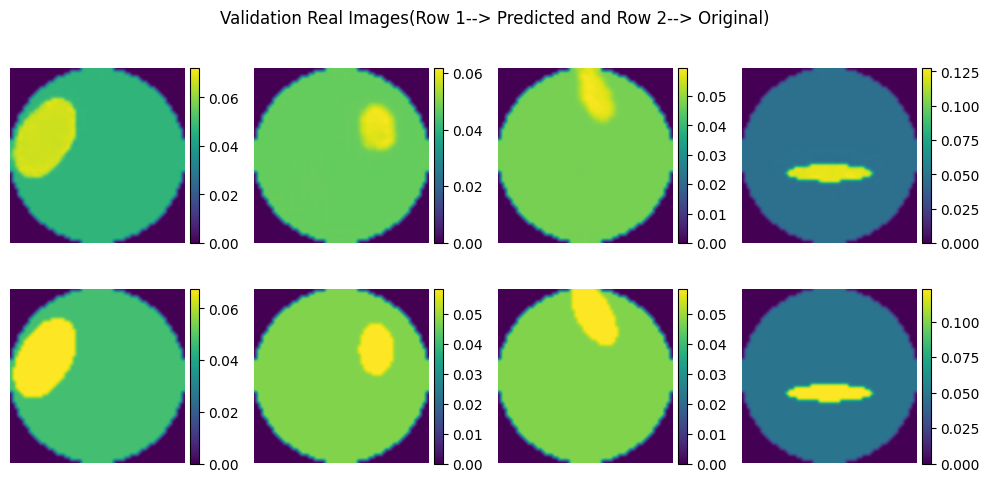

In [86]:
rows=2
columns=4
fig, axs = plt.subplots(rows,columns,figsize=(10,5))
fig.suptitle('Validation Real Images(Row 1--> Predicted and Row 2--> Original)')
for i in range(rows):
  k=0
  for j in range(columns):
    if i==0:
      im=axs[i,j].imshow(pred_op[k][:,:,0]*max_overall,interpolation="bicubic")
      divider = make_axes_locatable(axs[i,j])
      cax = divider.append_axes('right', size='5%', pad=0.05)
      fig.colorbar(im, cax=cax, orientation='vertical')
      axs[i,j].axis('off')
      k=k+1
    else:
      im=axs[i,j].imshow(train_op[val_index[k]][:,:,0]*max_overall,interpolation="bicubic")
      divider = make_axes_locatable(axs[i,j])
      cax = divider.append_axes('right', size='5%', pad=0.05)
      fig.colorbar(im, cax=cax, orientation='vertical')
      axs[i,j].axis('off')
      k=k+1
fig.tight_layout()

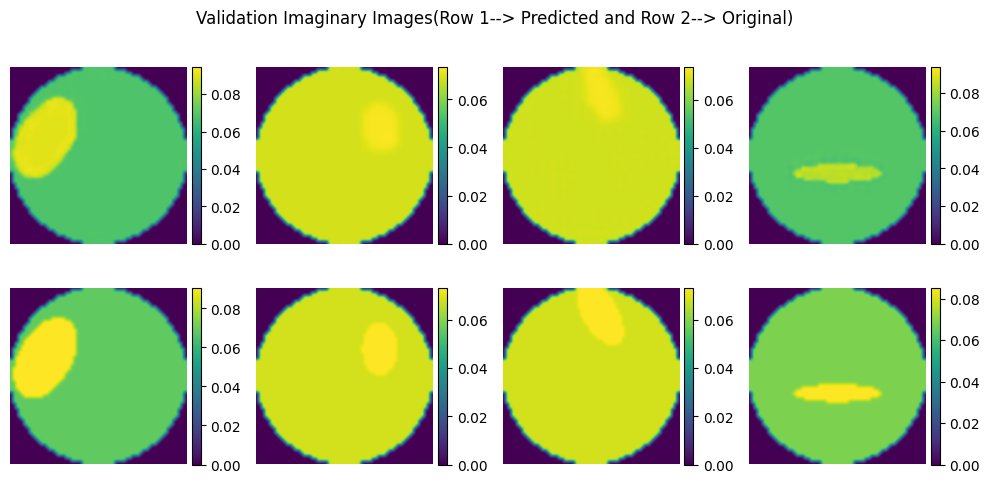

In [87]:
rows=2
columns=4
fig, axs = plt.subplots(rows,columns,figsize=(10,5))
fig.suptitle('Validation Imaginary Images(Row 1--> Predicted and Row 2--> Original)')
for i in range(rows):
  k=0
  for j in range(columns):
    if i==0:
      im=axs[i,j].imshow(pred_op[k][:,:,1]*max_overall,interpolation="bicubic")
      divider = make_axes_locatable(axs[i,j])
      cax = divider.append_axes('right', size='5%', pad=0.05)
      fig.colorbar(im, cax=cax, orientation='vertical')
      axs[i,j].axis('off')
      k=k+1
    else:
      im=axs[i,j].imshow(train_op[val_index[k]][:,:,1]*max_overall,interpolation="bicubic")
      divider = make_axes_locatable(axs[i,j])
      cax = divider.append_axes('right', size='5%', pad=0.05)
      fig.colorbar(im, cax=cax, orientation='vertical')
      axs[i,j].axis('off')
      k=k+1
fig.tight_layout()

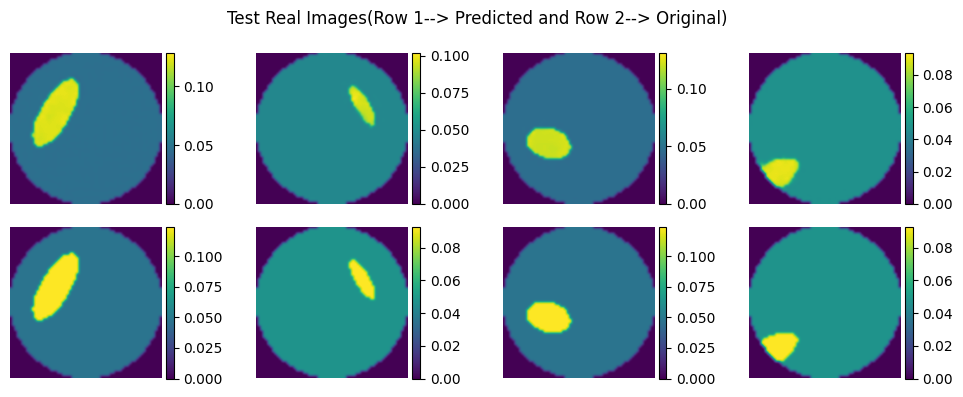

In [88]:
testpred_op=[]
test_index=np.random.randint(len(test_ip),size=4)
for i in test_index:
  ip=test_ip[i].reshape(1,32,32,4)
  op=model_1.predict(ip,verbose=0)
  op=np.squeeze(op,axis=0)
  testpred_op.append(op)
rows=2
columns=4
fig, axs = plt.subplots(rows,columns,figsize=(10,4))
fig.suptitle('Test Real Images(Row 1--> Predicted and Row 2--> Original)')
for i in range(rows):
  k=0
  for j in range(columns):
    if i==0:
      im=axs[i,j].imshow(testpred_op[k][:,:,0]*max_overall,interpolation="bicubic")
      divider = make_axes_locatable(axs[i,j])
      cax = divider.append_axes('right', size='5%', pad=0.05)
      fig.colorbar(im, cax=cax, orientation='vertical')
      axs[i,j].axis('off')
      k=k+1
    else:
      im=axs[i,j].imshow(test_op[test_index[k]][:,:,0]*max_overall,interpolation="bicubic")
      divider = make_axes_locatable(axs[i,j])
      cax = divider.append_axes('right', size='5%', pad=0.05)
      fig.colorbar(im, cax=cax, orientation='vertical')
      axs[i,j].axis('off')
      k=k+1
fig.tight_layout()

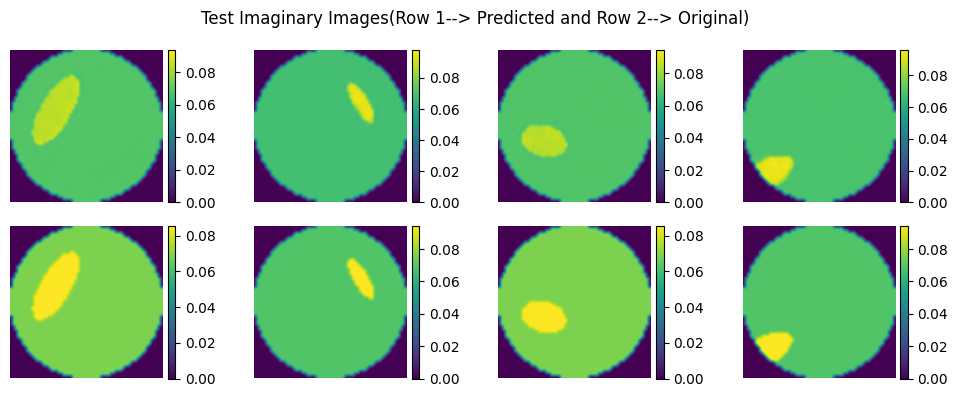

In [89]:
rows=2
columns=4
fig, axs = plt.subplots(rows,columns,figsize=(10,4))
fig.suptitle('Test Imaginary Images(Row 1--> Predicted and Row 2--> Original)')
for i in range(rows):
  k=0
  for j in range(columns):
    if i==0:
      im=axs[i,j].imshow(testpred_op[k][:,:,1]*max_overall,interpolation="bicubic")
      divider = make_axes_locatable(axs[i,j])
      cax = divider.append_axes('right', size='5%', pad=0.05)
      fig.colorbar(im, cax=cax, orientation='vertical')
      axs[i,j].axis('off')
      k=k+1
    else:
      im=axs[i,j].imshow(test_op[test_index[k]][:,:,1]*max_overall,interpolation="bicubic")
      divider = make_axes_locatable(axs[i,j])
      cax = divider.append_axes('right', size='5%', pad=0.05)
      fig.colorbar(im, cax=cax, orientation='vertical')
      axs[i,j].axis('off')
      k=k+1
fig.tight_layout()

In [91]:
from skimage.metrics import structural_similarity as ssim
ssim_score=[]
for i in range(len(test_index)):
  (score, diff) = ssim(testpred_op[i], test_op[test_index[i]], full=True,channel_axis=2)
  ssim_score.append(score)
print(np.mean(ssim_score))

0.99852765


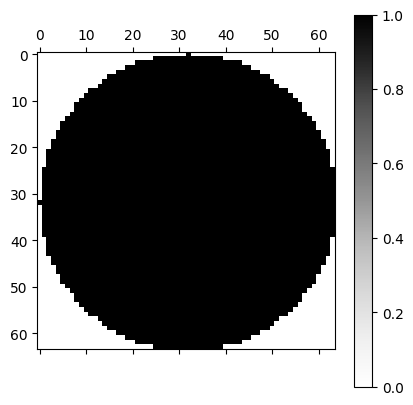

In [98]:
from sklearn.preprocessing import Binarizer
def quantize_binary(X):
  transformer = Binarizer(threshold=0.90*np.max(X)).fit(X)
  Xt=transformer.transform(X)
  return np.array(Xt,dtype='bool')
def create_circular_mask(h, w):
    center = (int(w/2), int(h/2))
    radius = (center[0], center[1], w-center[0], h-center[1])
    radius=np.min(radius)
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
    mask = dist_from_center <= radius
    return np.array(mask,dtype='bool')
cir_mask=create_circular_mask(64,64)
plt.matshow(cir_mask,cmap='Greys')
plt.colorbar()
plt.show()

In [24]:
from google.colab import files
uploaded = files.upload()

Saving eval_data.zip to eval_data.zip


In [25]:
!unzip "/content/eval_data.zip"

Archive:  /content/eval_data.zip
   creating: eval_data/ideal_op/
  inflating: eval_data/ideal_op/iop_1.mat  
  inflating: eval_data/ideal_op/iop_10.mat  
  inflating: eval_data/ideal_op/iop_11.mat  
  inflating: eval_data/ideal_op/iop_12.mat  
  inflating: eval_data/ideal_op/iop_13.mat  
  inflating: eval_data/ideal_op/iop_14.mat  
  inflating: eval_data/ideal_op/iop_15.mat  
  inflating: eval_data/ideal_op/iop_16.mat  
  inflating: eval_data/ideal_op/iop_17.mat  
  inflating: eval_data/ideal_op/iop_18.mat  
  inflating: eval_data/ideal_op/iop_19.mat  
  inflating: eval_data/ideal_op/iop_2.mat  
  inflating: eval_data/ideal_op/iop_20.mat  
  inflating: eval_data/ideal_op/iop_3.mat  
  inflating: eval_data/ideal_op/iop_4.mat  
  inflating: eval_data/ideal_op/iop_5.mat  
  inflating: eval_data/ideal_op/iop_6.mat  
  inflating: eval_data/ideal_op/iop_7.mat  
  inflating: eval_data/ideal_op/iop_8.mat  
  inflating: eval_data/ideal_op/iop_9.mat  
   creating: eval_data/ip/
  inflating: eva

In [93]:
dbar_op=[]
dbar_op_norm=[]
min_dbar1,max_dbar1=[],[]
min_dbar2,max_dbar2=[],[]
for ind in range(1,2316):
  name='/content/cond+data/op/'+'op_'+str(ind)+'.mat'
  op_mat = scipy.io.loadmat(name)
  mindbar1=np.min(op_mat["C"][:,:,0])
  mindbar2=np.min(op_mat["C"][:,:,1])
  maxdbar1=np.max(op_mat["C"][:,:,0])
  maxdbar2=np.max(op_mat["C"][:,:,1])
  dbar_op.append(np.array(op_mat['C'],dtype='float32'))
  min_dbar1.append(mindbar1)
  min_dbar2.append(mindbar1)
  max_dbar1.append(maxdbar1)
  max_dbar2.append(maxdbar2)
min_dbar_overall1=np.min(min_dbar1)
min_dbar_overall2=np.min(min_dbar2)
max_dbar_overall1=np.max(max_dbar1)
max_dbar_overall2=np.max(max_dbar2)

In [94]:
eval_ip=[]
for ind in range(1,21):
  name='/content/eval_data/ip/'+'ip_'+str(ind)+'.mat'
  ip_mat = scipy.io.loadmat(name)
  ip=np.array(ip_mat["S"],dtype='float32')
  evalip=(ip-np.min(min_ip))/(np.max(max_ip)-np.min(min_ip))
  eval_ip.append(evalip)
print(np.shape(eval_ip))

(20, 32, 32, 4)


In [95]:
eval_data_iop=[]
eval_data_dbar=[]
eval_data_dbar_norm=[]
for ind in range(1,21):
  name='/content/eval_data/ideal_op/'+'iop_'+str(ind)+'.mat'
  op_mat = scipy.io.loadmat(name)
  opmat=op_mat["Ci"]/max_overall
  eval_data_iop.append(np.array(opmat,dtype='float32'))
for ind in range(1,21):
  name='/content/eval_data/op/'+'op_'+str(ind)+'.mat'
  op_mat = scipy.io.loadmat(name)
  eval_data_dbar.append(np.array(op_mat['C'],dtype='float32'))
  a=op_mat["C"][:,:,0]
  b=op_mat["C"][:,:,1]
  aa=(a-min_dbar_overall1)/(max_dbar_overall1-min_dbar_overall1)
  bb=(b-min_dbar_overall2)/(max_dbar_overall2-min_dbar_overall2)
  dbar_norm=np.stack((aa,bb),axis=-1)
  eval_data_dbar_norm.append(dbar_norm)
print(np.shape(eval_data_iop),np.shape(eval_data_dbar_norm))

(20, 64, 64, 2) (20, 64, 64, 2)


In [99]:
testpred_anal_op=[]
ssim_overall=[]
ARall_r,ARall_i=[],[]
RNGall_r,RNGall_i=[],[]

for i in range(len(eval_ip)):
  ip=eval_ip[i].reshape(1,32,32,4)
  op=model_1.predict(ip,verbose=0)
  op=np.squeeze(op,axis=0)
  testpred_anal_op.append(op)

for i in range(len(testpred_anal_op)):
  a=testpred_anal_op[i][:,:,0]
  b=testpred_anal_op[i][:,:,1]
  mask_a=quantize_binary(a)
  mask_b=quantize_binary(b)
  not_mask_a=(~mask_a)*cir_mask
  not_mask_b=(~mask_b)*cir_mask
  AR_real=np.sum(mask_a*a)
  AR_imag=np.sum(mask_b*b)
  RNG_real=np.std((not_mask_a)*a)
  RNG_imag=np.std((not_mask_b)*b)
  ARall_r.append(AR_real)
  ARall_i.append(AR_imag)
  RNGall_r.append(RNG_real)
  RNGall_i.append(RNG_imag)
  (score, diff) = ssim(testpred_anal_op[i], test_op[i], full=True,channel_axis=2)
  ssim_overall.append(score)

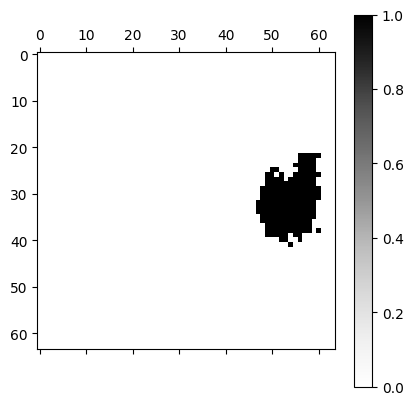

In [100]:
plt.matshow(mask_b,cmap='Greys')
plt.colorbar()
plt.show()

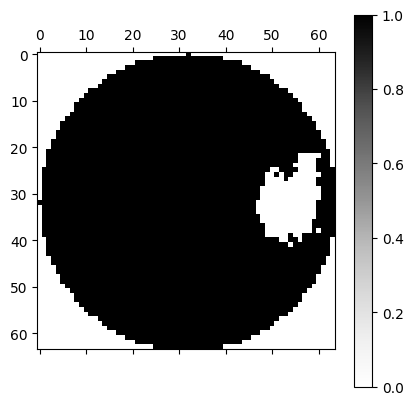

In [101]:
plt.matshow(not_mask_b,cmap='Greys')
plt.colorbar()
plt.show()

Checking Noisy data to see the performance of the model

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving test_cond+data1.zip to test_cond+data1 (1).zip


In [ ]:
!unzip '/content/test_cond+data1.zip'

Archive:  /content/test_cond+data1.zip
replace test_cond+data1/ideal_op/iop_1.mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: test_cond+data1/ideal_op/iop_1.mat  
  inflating: test_cond+data1/ideal_op/iop_2.mat  
  inflating: test_cond+data1/ideal_op/iop_3.mat  
  inflating: test_cond+data1/ideal_op/iop_4.mat  
  inflating: test_cond+data1/ideal_op/iop_5.mat  
  inflating: test_cond+data1/ideal_op/iop_6.mat  
  inflating: test_cond+data1/ideal_op/iop_7.mat  
  inflating: test_cond+data1/ideal_op/iop_8.mat  
  inflating: test_cond+data1/ip/ip_1.mat  
  inflating: test_cond+data1/ip/ip_2.mat  
  inflating: test_cond+data1/ip/ip_3.mat  
  inflating: test_cond+data1/ip/ip_4.mat  
  inflating: test_cond+data1/ip/ip_5.mat  
  inflating: test_cond+data1/ip/ip_6.mat  
  inflating: test_cond+data1/ip/ip_7.mat  
  inflating: test_cond+data1/ip/ip_8.mat  
  inflating: test_cond+data1/op/op_1.mat  
  inflating: test_cond+data1/op/op_2.mat  
  inflating: test_cond+data1/op/op_3.mat  
  in

In [ ]:
noise_ip=[]

for ind in range(1,9):
  name='/content/test_cond+data1/ip/'+'ip_'+str(ind)+'.mat'
  ip_mat = scipy.io.loadmat(name)
  data=(ip_mat['S']-np.min(min_ip))/(np.max(max_ip)-np.min(min_ip))
  noise_ip.append(np.array(data,dtype='float32'))

noise_op_actual=[]
for ind in range(1,9):
  name='/content/test_cond+data1/op/'+'op_'+str(ind)+'.mat'
  op_mat = scipy.io.loadmat(name)
  noise_op_actual.append(np.array(op_mat["C"],dtype='float32'))
print(np.shape(noise_op_actual))

noise_op_ideal=[]
for ind in range(1,9):
  name='/content/test_cond+data1/ideal_op/'+'iop_'+str(ind)+'.mat'
  op_mat = scipy.io.loadmat(name)
  noise_op_ideal.append(np.array(op_mat["Ci"],dtype='float32'))
print(np.shape(noise_op_ideal))



(8, 64, 64, 2)
(8, 64, 64, 2)


In [ ]:
noise_op_pred=[]
for i in range(len(noise_ip)):
  ip=noise_ip[i].reshape(1,32,32,4)
  op=model_1.predict(ip,verbose=0)
  op=np.squeeze(op,axis=0)
  noise_op_pred.append(op)

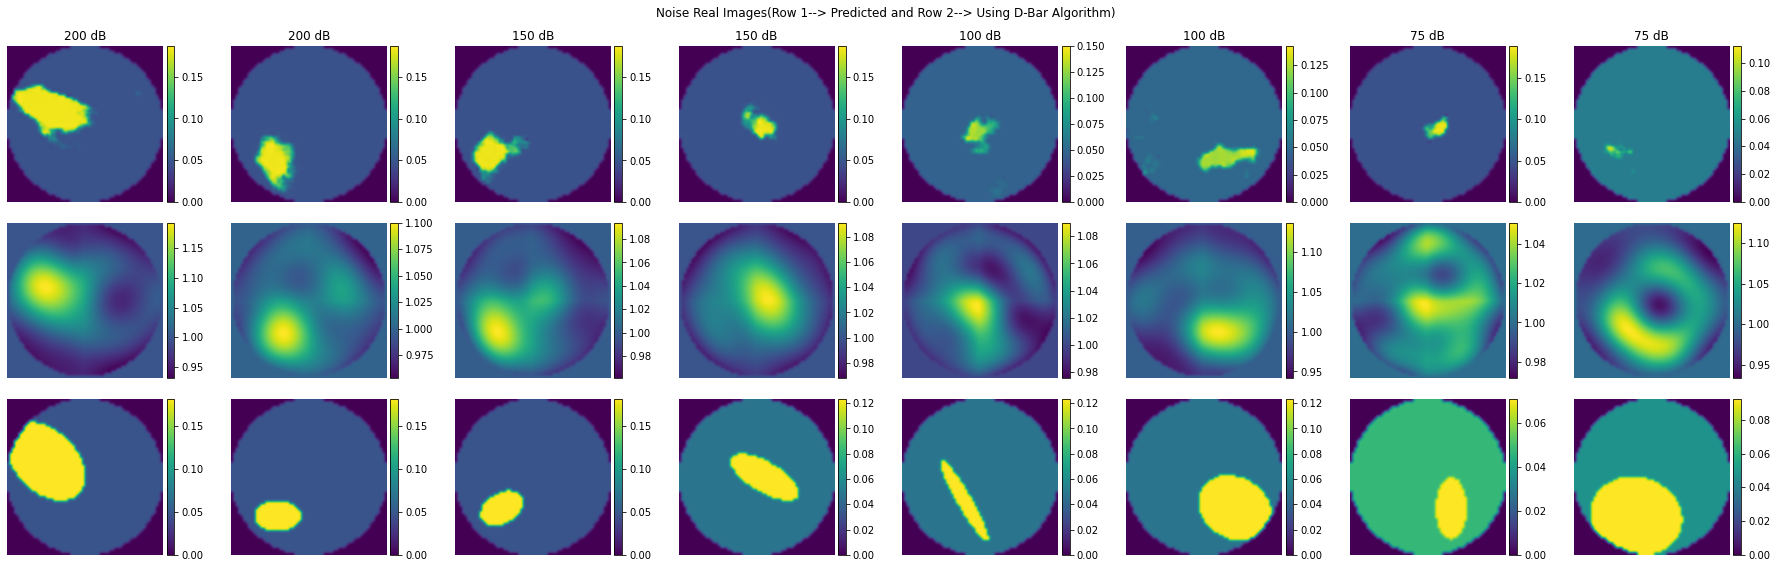

In [ ]:
rows=3
columns=8
noise=['200 dB',"200 dB",'150 dB',"150 dB","100 dB","100 dB","75 dB","75 dB"]
fig, axs = plt.subplots(rows,columns,figsize=(25,8))
fig.suptitle('Noise Real Images(Row 1--> Predicted and Row 2--> Using D-Bar Algorithm)')
for i in range(rows):
  k=0
  for j in range(columns):
    if i==0:
      im=axs[i,j].imshow(noise_op_pred[k][:,:,0]*max_overall,interpolation="bicubic")
      divider = make_axes_locatable(axs[i,j])
      cax = divider.append_axes('right', size='5%', pad=0.05)
      fig.colorbar(im, cax=cax, orientation='vertical')
      axs[i,j].set_title(noise[j])
      axs[i,j].axis('off')
      k=k+1
    elif i==1:
      im=axs[i,j].imshow(noise_op_actual[k][:,:,0],interpolation="bicubic")
      divider = make_axes_locatable(axs[i,j])
      cax = divider.append_axes('right', size='5%', pad=0.05)
      fig.colorbar(im, cax=cax, orientation='vertical')
      axs[i,j].axis('off')
      k=k+1
    else:
      im=axs[i,j].imshow(noise_op_ideal[k][:,:,0],interpolation="bicubic")
      divider = make_axes_locatable(axs[i,j])
      cax = divider.append_axes('right', size='5%', pad=0.05)
      fig.colorbar(im, cax=cax, orientation='vertical')
      axs[i,j].axis('off')
      k=k+1
fig.tight_layout()

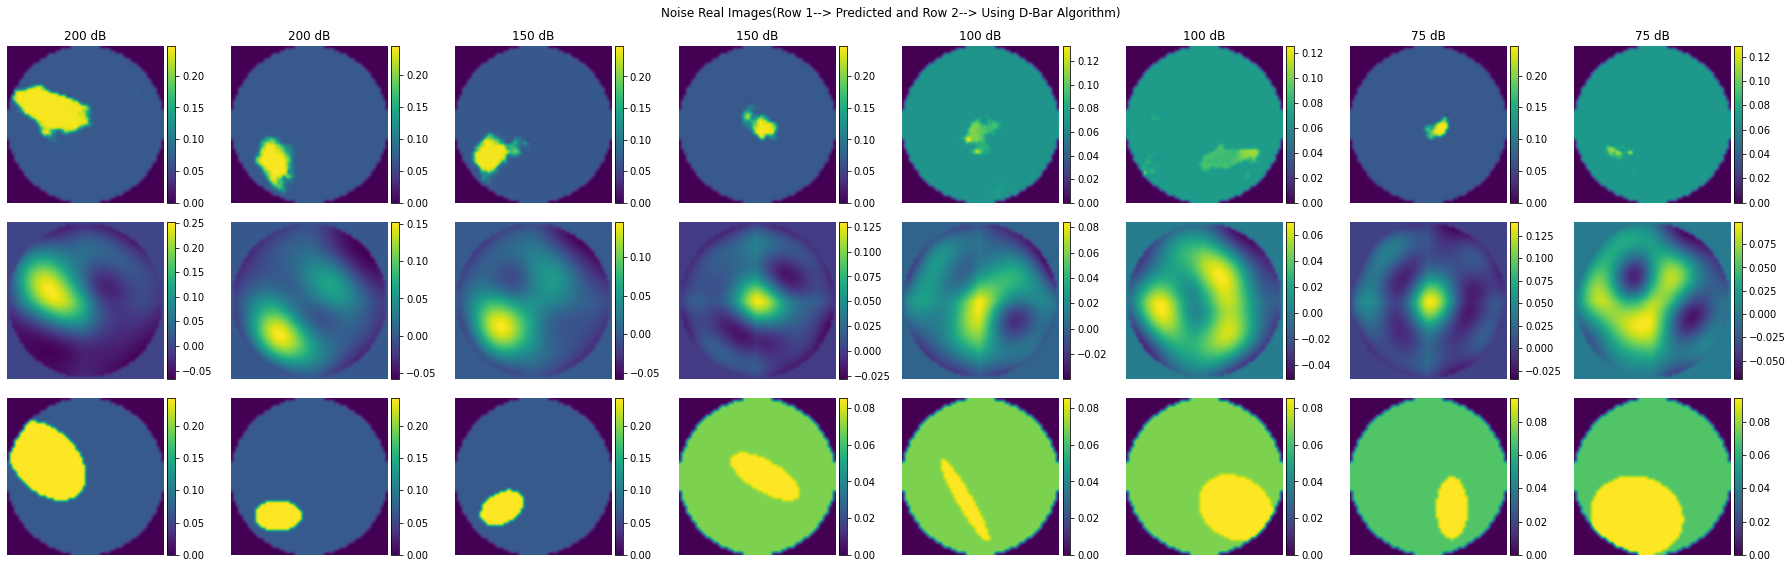

In [ ]:
rows=3
columns=8
noise=['200 dB',"200 dB",'150 dB',"150 dB","100 dB","100 dB","75 dB","75 dB"]
fig, axs = plt.subplots(rows,columns,figsize=(25,8))
fig.suptitle('Noise Real Images(Row 1--> Predicted and Row 2--> Using D-Bar Algorithm)')
for i in range(rows):
  k=0
  for j in range(columns):
    if i==0:
      im=axs[i,j].imshow(noise_op_pred[k][:,:,1]*max_overall,interpolation="bicubic")
      divider = make_axes_locatable(axs[i,j])
      cax = divider.append_axes('right', size='5%', pad=0.05)
      fig.colorbar(im, cax=cax, orientation='vertical')
      axs[i,j].set_title(noise[j])
      axs[i,j].axis('off')
      k=k+1
    elif i==1:
      im=axs[i,j].imshow(noise_op_actual[k][:,:,1],interpolation="bicubic")
      divider = make_axes_locatable(axs[i,j])
      cax = divider.append_axes('right', size='5%', pad=0.05)
      fig.colorbar(im, cax=cax, orientation='vertical')
      axs[i,j].axis('off')
      k=k+1
    else:
      im=axs[i,j].imshow(noise_op_ideal[k][:,:,1],interpolation="bicubic")
      divider = make_axes_locatable(axs[i,j])
      cax = divider.append_axes('right', size='5%', pad=0.05)
      fig.colorbar(im, cax=cax, orientation='vertical')
      axs[i,j].axis('off')
      k=k+1
fig.tight_layout()

Analysis for the D-bar algorithm output:

In [ ]:
# test_dbar_op=[eval_dbar_op[ind] for ind in test_ind]
# print(np.shape(test_dbar_op),np.shape(testpred_anal_op))

(116, 64, 64, 2) (116, 64, 64, 2)


In [102]:
ssim_overall_dbar=[]
ARall_r_dbar,ARall_i_dbar=[],[]
RNGall_r_dbar,RNGall_i_dbar=[],[]
for i in range(len(eval_data_dbar_norm)):
  c=eval_data_dbar_norm[i][:,:,0]
  d=eval_data_dbar_norm[i][:,:,1]
  mask_c=quantize_binary(c)
  mask_d=quantize_binary(d)
  not_mask_c=(~mask_c)*cir_mask
  not_mask_d=(~mask_d)*cir_mask
  AR_real_dbar=np.sum(mask_c*c)
  AR_imag_dbar=np.sum(mask_d*d)
  RNG_real_dbar=np.std((not_mask_c)*c)
  RNG_imag_dbar=np.std((not_mask_d)*d)
  ARall_r_dbar.append(AR_real_dbar)
  ARall_i_dbar.append(AR_imag_dbar)
  RNGall_r_dbar.append(RNG_real_dbar)
  RNGall_i_dbar.append(RNG_imag_dbar)
  # (score_dbar, diff) = ssim(eval_dbar_op[i], test_op[i], full=True,channel_axis=2)
  # ssim_overall_dbar.append(score_dbar)
print(i)

19


In [105]:
ARall_ri,ARall_ii=[],[]
RNGall_ri,RNGall_ii=[],[]

for i in range(len(eval_data_iop)):
  ai=eval_data_iop[i][:,:,0]
  bi=eval_data_iop[i][:,:,1]
  mask_ai=quantize_binary(ai)
  mask_bi=quantize_binary(bi)
  not_mask_ai=(~mask_ai)*cir_mask
  not_mask_bi=(~mask_bi)*cir_mask
  AR_reali=np.sum(mask_ai*ai)
  AR_imagi=np.sum(mask_bi*bi)
  RNG_reali=np.std((not_mask_ai)*ai)
  RNG_imagi=np.std((not_mask_bi)*bi)
  ARall_ri.append(AR_reali)
  ARall_ii.append(AR_imagi)
  RNGall_ri.append(RNG_reali)
  RNGall_ii.append(RNG_imagi)

In [106]:
print("Amplitude Response for Real Images:",np.mean(ARall_r),"+-",np.std(ARall_r))
print("Amplitude Response for Imaginary Images:",np.mean(ARall_i),"+-",np.std(ARall_i))
print("Ringing for Real Images:",np.mean(RNGall_r),"+-",np.std(RNGall_r))
print("Ringing for Imaginary Images:",np.mean(RNGall_i),"+-",np.std(RNGall_i))
#print("SSIM for both:",np.mean(ssim_overall),"+-",np.std(ssim_overall))

Amplitude Response for Real Images: 98.40348 +- 58.091908
Amplitude Response for Imaginary Images: 123.59332 +- 64.93362
Ringing for Real Images: 0.1000304 +- 0.016917337
Ringing for Imaginary Images: 0.1373184 +- 0.017567728


In [107]:
print("Amplitude Response for Real Images:",np.mean(ARall_r_dbar),"+-",np.std(ARall_r_dbar))
print("Amplitude Response for Imaginary Images:",np.mean(ARall_i_dbar),"+-",np.std(ARall_i_dbar))
print("Ringing for Real Images:",np.mean(RNGall_r_dbar),"+-",np.std(RNGall_r_dbar))
print("Ringing for Imaginary Images:",np.mean(RNGall_i_dbar),"+-",np.std(RNGall_i_dbar))

Amplitude Response for Real Images: 73.4865796222214 +- 34.79424302269918
Amplitude Response for Imaginary Images: 5480.515377922216 +- 364.7922363464803
Ringing for Real Images: 0.16252941001788482 +- 0.012954460683297114
Ringing for Imaginary Images: 0.1623971220201042 +- 0.18352807434108534


In [109]:
print("Amplitude Response for Real Images of dbar:",np.absolute(np.mean(ARall_r_dbar)-np.mean(ARall_ri)),"+-",np.absolute(np.std(ARall_r_dbar)-np.std(ARall_ri)))
print("Amplitude Response for Imaginary Images of dbar:",np.absolute(np.mean(ARall_i_dbar)-np.mean(ARall_ii)),"+-",np.absolute(np.std(ARall_i_dbar)-np.std(ARall_ii)))
print("Ringing for Real Images of dbar:",np.absolute(np.mean(RNGall_r_dbar)-np.mean(RNGall_ri)),"+-",np.absolute(np.std(RNGall_r_dbar)-np.std(RNGall_ri)))
print("Ringing for Imaginary Images of dbar:",np.absolute(np.mean(RNGall_i_dbar)-np.mean(RNGall_ii)),"+-",np.absolute(np.std(RNGall_i_dbar))-np.std(RNGall_ii))
#print("SSIM for both of dbar:",np.mean(ssim_overall_dbar),"+-",np.std(ssim_overall_dbar))

Amplitude Response for Real Images of dbar: 43.742935453462195 +- 9.332492664556682
Amplitude Response for Imaginary Images of dbar: 5306.4177369310055 +- 182.67446901249593
Ringing for Real Images of dbar: 0.07444985319510802 +- 0.012371015029977755
Ringing for Imaginary Images of dbar: 0.041169157261231215 +- 0.15570384757426062


In [110]:
print("Amplitude Response for Real Images:",np.absolute(np.mean(ARall_r)-np.mean(ARall_ri)),"+-",np.absolute(np.std(ARall_r)-np.std(ARall_ri)))
print("Amplitude Response for Imaginary Images:",np.absolute(np.mean(ARall_i)-np.mean(ARall_ii)),"+-",np.absolute(np.std(ARall_i)-np.std(ARall_ii)))
print("Ringing for Real Images:",np.absolute(np.mean(RNGall_r)-np.mean(RNGall_ri)),"+-",np.absolute(np.std(RNGall_r)-np.std(RNGall_ri)))
print("Ringing for Imaginary Images:",np.absolute(np.mean(RNGall_i)-np.mean(RNGall_ii)),"+-",np.absolute(np.std(RNGall_i)-np.std(RNGall_ii)))
#print("SSIM for both:",np.mean(ssim_overall),"+-",np.std(ssim_overall))

Amplitude Response for Real Images: 18.826035 +- 13.965172
Amplitude Response for Imaginary Images: 50.50432 +- 117.18415
Ringing for Real Images: 0.011950843 +- 0.016333891
Ringing for Imaginary Images: 0.016090438 +- 0.010256499
